##Text mining and search exam notebook: pLSA.
Authors: Gaetano Chiriaco, Riccardo Porcedda, Gianmarco Russo.


#Drive mount and imports

In [ ]:
!pip install plsa
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from plsa import Corpus, Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE,tokenize
from plsa.algorithms import PLSA
import pandas as pd
import re
from gensim.models.phrases import Phrases


from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preprocessing

In [ ]:
#lets load the data
df = pd.read_csv('drive/MyDrive/TM&S/data/main_ridotto.csv')

In [ ]:
df.head(5)
#we will only need the 'sentences' column

,title,sentences
0,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is..."
1,Bayesian Query Construction for Neural Network...,In this paper we consider the situation wher...
2,"Neural Network Ensembles, Cross Validation, an...",It is well known that a combination of many ...
3,Pulsestream Synapses with Non-Volatile Analogu...,Fusion of the nuclei of hydrogen provides th...
4,Learning to Play the Game of Chess,"Throughout the last decades, the game of ches..."


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


def remove_punctuation(text):
    # String punctuation: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def character_repetition(text):
    # Pattern matching for all case alphabets
    # \1   It refers to the first capturing group.
    # {1,} It means we are matching for repetition that occurs more than one time.
    # r’\1\1' → It limits all the repetition to two characters.
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    return Formatted_text

def remove_spaces(text):
    return text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('  ', ' ').replace('\n\n',' ')


def remove_stopwords(tokenized_text):
  stop_words = stopwords.words('english')
  tokenized_text_without_stopwords = []
  for token in tokenized_text:
    if token.lower() not in stop_words and len(token)>2 and token.lower()!="fig":
      tokenized_text_without_stopwords.append(token)
  return tokenized_text_without_stopwords


def lemmatization(tokenized_text):
  wnl = WordNetLemmatizer()
  n_words = len(tokenized_text)
  for idx in range(n_words):
    tokenized_text[idx] = wnl.lemmatize(tokenized_text[idx])
  return tokenized_text


def stemming(tokenized_text):
    stemmer = SnowballStemmer("english")
    n_words = len(tokenized_text)
    for idx in range(n_words):
      tokenized_text[idx] = stemmer.stem(tokenized_text[idx])
    return tokenized_text
    

def preprocess(text,stopword = True, lemma = True,stem=False):
  tokenized_text =  WordPunctTokenizer().tokenize(text)
  if stopword:
    tokenized_text = remove_stopwords(tokenized_text)
  
  if lemma:
    tokenized_text = lemmatization(tokenized_text)
  
  if stem:
    tokenized_text = stemming(tokenized_text)

  return tokenized_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
main_text = df["sentences"]

In [ ]:
# Puctuation removal
main_text = main_text.apply(lambda x: remove_punctuation(x))
# all lower case
main_text = main_text.apply(lambda x: x.lower())
# digits removal
main_text = main_text.apply(lambda x: re.sub(r'\d+', '', x))
# repeatead character removal
main_text = main_text.apply(lambda x: character_repetition(x))
# excess space removal
main_text = main_text.apply(lambda x: remove_spaces(x))
# lemmatization and stop words removal
main_text = main_text.apply(lambda x: preprocess(x))

In [ ]:
text = pd.DataFrame(main_text)

In [ ]:
#loading of bigrams and trigrams models 
phrase_model = Phrases.load("drive/MyDrive/TM&S/models/bigrams_model.pkl")
phrase_model_tri = Phrases.load("drive/MyDrive/TM&S/models/trigrams_model.pkl")

In [ ]:
import _pickle as cPickle

with open(r"drive/MyDrive/TM&S/models/main_bow.pkl", "rb") as input_file:
   filt_dict = cPickle.load(input_file)


In [ ]:
filt_dict_l = [filt_dict[w] for w in filt_dict] 

In [ ]:
# substitution of word coupls with bigrams
text["sentences_bi"] = phrase_model[text["sentences"]]

In [ ]:
# substitution of word triples with trigrams 
text["sentences_tri"] = phrase_model_tri[text["sentences_bi"]]

In [ ]:
#this function filters extreme words using the dict created with gensim for the LDA notebook
def filt_words(l):
  l_filt = [w for w in l if w in filt_dict_l]
  return l_filt

This is a workaround: the library requires its pipeline object to be passed but we applied our own preprocessing(same as LDA) so we de-tokenized and used the default tokenizer.

In [ ]:
text["sentences_filt"] = text["sentences_tri"].apply(filt_words)

In [ ]:
def de_token(l):
  return " ".join(l)

In [ ]:
text["sentences_str"] = text["sentences_filt"].apply(de_token)

In [ ]:
text["sentences_str"].to_csv('drive/MyDrive/TM&S/data/main_plsa.csv') #optional: we are saving it into another dataframe

In [ ]:
csv_file = 'drive/MyDrive/TM&S/data/main_plsa.csv' #path for information loading

In [ ]:
pipeline = Pipeline(tokenize)
pipeline

Pipeline:
0: tokenize

#pLSA

In [ ]:
corpus = Corpus.from_csv(csv_file,pipeline ,max_docs=1000) 
#this function takes the documents and operates a preprocessing pipeline
#(max_doc=1000) for computational reasons(memory).

In [ ]:
n_topics=10 #number of topic to model 

In [ ]:
plsa = PLSA(corpus, n_topics, True) 
plsa #lets see our model parameters

PLSA:
====
Number of topics:     10
Number of documents:  1000
Number of words:      20745
Number of iterations: 0

In [ ]:
result = plsa.fit() #fit the model
plsa

PLSA:
====
Number of topics:     10
Number of documents:  1000
Number of words:      20745
Number of iterations: 138

In [ ]:
result = plsa.best_of(5) #take the best out of 5 models that we created

In [ ]:
result.topic

array([0.12865925, 0.11918453, 0.10552758, 0.10067057, 0.0980432 ,
       0.09500674, 0.09329344, 0.09280097, 0.09089409, 0.07591962])

In [ ]:
result.word_given_topic[0][:10] #top 10 words for the first topic 

(('stimulus', 0.008948094115669731),
 ('image', 0.008644414331410903),
 ('object', 0.004783340602002732),
 ('cell', 0.004606993336809005),
 ('neuron', 0.0036145620084032577),
 ('response', 0.003609933864498197),
 ('pixel', 0.0032396706436732996),
 ('orientation', 0.0028877806887399565),
 ('motion', 0.002839764137437113),
 ('receptive_field', 0.0027437042809381382))

In [ ]:
import numpy as np

In [ ]:
#this function assigns the most probable topic to a document
def assign_topic(model): 
  docs_tuples = model.topic_given_doc
  topic_docs = [0]*docs_tuples.shape[0]
  max_prob_docs = [0]*docs_tuples.shape[0]
  for n in range(docs_tuples.shape[0]):
    topic = np.argmax(docs_tuples[n])
    prob = np.max(docs_tuples[n])
    topic_docs[n] = topic
    max_prob_docs[n] = prob
  
  return topic_docs, max_prob_docs

In [ ]:
topic_list,topic_prob = assign_topic(result)

In [ ]:
#this function assigns more than one topic to a documument if the probability is 
# greater than .25 for each topic
def assign_multitopic(model,threshold = 0.25):
  docs = model.topic_given_doc
  topic_docs = []
  for n in range(len(docs)):
    probs = docs[n]
    topic_l=[]
    for i in range(len(probs)):
      if probs[i]>threshold:
        topic_l.append(i)
    topic_docs.append(topic_l)
  
  return topic_docs

In [ ]:
multi_topic = assign_multitopic(result)
multi_topic[0:20]

[[7],
 [6, 7],
 [6],
 [2],
 [4],
 [3, 6],
 [7],
 [7],
 [7],
 [0],
 [0],
 [3, 7],
 [9],
 [4],
 [5],
 [0],
 [0, 7],
 [8, 9],
 [5, 8],
 [0]]

We are going to create a dataframe containg the results, in particular having:


*   Document text
*   Main topic assigned 
*   Probabilty of the document belonging to that topic
*   Other relevant topic assignable (if any)



In [ ]:
final = pd.DataFrame()
final['Main'] = df['sentences'][0:1000]
final['Topic'] = topic_list
final['pTopic'] = topic_prob
final['Multitopic'] = multi_topic

In [ ]:
final.head()

,Main,Topic,pTopic,Multitopic
0,"Let a mapping f : X -+ Y be given. Here, X is...",7,0.854829,[7]
1,In this paper we consider the situation wher...,7,0.343182,"[6, 7]"
2,It is well known that a combination of many ...,6,0.810461,[6]
3,Fusion of the nuclei of hydrogen provides th...,2,0.913870,[2]
4,"Throughout the last decades, the game of ches...",4,0.816128,[4]


In [ ]:
final.to_csv("/content/drive/MyDrive/TM&S/data/results_PLSA.csv")

#Visualization of the results:

In [ ]:
visualize = Visualize(result)
visualize

Visualize:
Number of topics:    10
Number of documents: 1000
Number of words:     20745

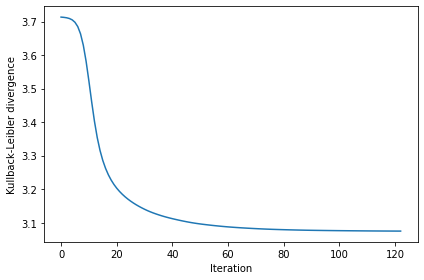

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
_ = visualize.convergence(ax)
fig.tight_layout()

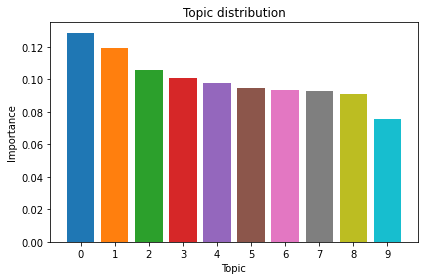

In [ ]:
fig, ax = plt.subplots()
_ = visualize.topics(ax)
fig.tight_layout()

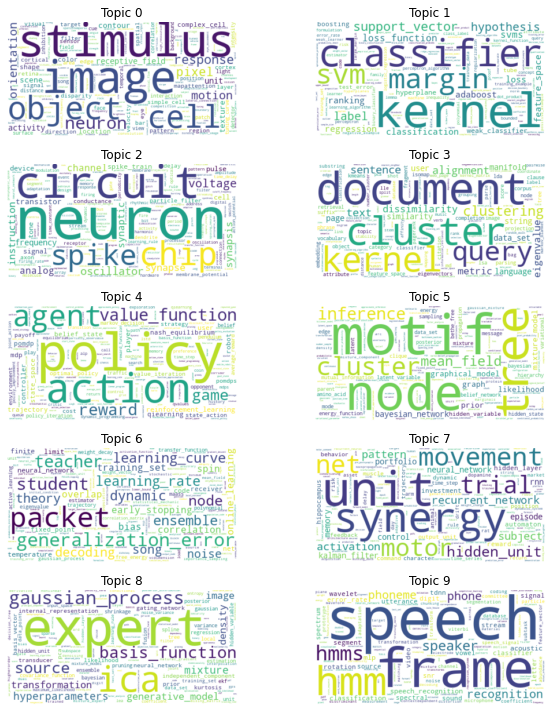

In [ ]:
fig = plt.figure(figsize=(9.4, 10))
_ = visualize.wordclouds(fig)